## Imports and Files

In [1294]:
# Classic Imports 
import pandas as pd
import numpy as np

import math
import time

# Accessing File Imports 
from pathlib import Path

# Plotting Imports 
from matplotlib import pyplot as plt

# Library FFT Imports 
from scipy.fft import fft, fftfreq

# Custom Imports
from wave_generator import create_wave

# All Relevant Variables 
csv_sampling_frequency = 250000
csv_num_data_points = 16384

is_data_from_sampleData1 = False

### Importing from sampleData1

In [1295]:
if (is_data_from_sampleData1 == True):

    # CSV Being Analyzed 
    dataFile = "./sampleData1/1.csv"

    def load_hydrophone_data():
        return pd.read_csv(Path(dataFile), header = None)

    hydrophoneData = load_hydrophone_data()

    def addTime(x): 
        return x / csv_sampling_frequency

    hydrophoneData.columns = ['hydrophone1', 'hydrophone2', 'hydrophone3', 'hydrophone4', 'time'] 
    hydrophoneData["time"] = hydrophoneData["time"].apply(addTime)

    sample = np.array(hydrophoneData["hydrophone1"])
    sampling_frequency = 250000

### Importing from sampleData2

In [1296]:
if (is_data_from_sampleData1 == False):

    # CSV Being Analyzed 
    dataFile = "./sampleData2/hydro3_3.5mA_close.csv"

    def load_hydrophone_data():
        return pd.read_csv(Path(dataFile), skiprows = 9)
    
    sample = load_hydrophone_data()

    sample = np.array(sample["Channel 1 (V)"])
    sampling_frequency = 160000

## Data Visualizer 

In [1297]:
sample                                  # Gives first couple of lines of the csv

array([4.30344429, 4.29880449, 4.30510136, ..., 4.31007257, 4.29449611,
       4.29714742])

## Temporary Manual Bandpass Filter 

In [1298]:
print("The original sample is ")
print(sample)
print("\n")

shift = float(np.mean(sample))

print("This is the shift by which all the values are shifted which is " + str(shift))
print("\n")

sample = sample - shift

print("The shifted and modified sample is + ")
print(sample)

The original sample is 
[4.30344429 4.29880449 4.30510136 ... 4.31007257 4.29449611 4.29714742]


This is the shift by which all the values are shifted which is 4.304043560642896


The shifted and modified sample is + 
[-0.00059927 -0.00523907  0.0010578  ...  0.00602901 -0.00954745
 -0.00689614]


In [1299]:
sample = sample * 100

<AxesSubplot: >

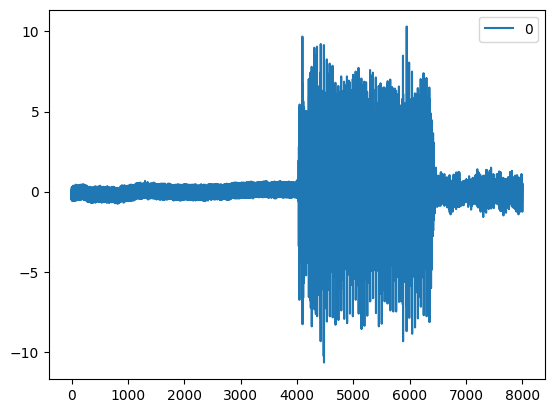

In [1300]:
sample1 = sample[0:8000]
sample1 = pd.DataFrame(sample1)

sample1.plot()

## Fourier Transform

In [1301]:
sampling_frequency                          # Sampling frequency of the hydrophone
N = 200                                     # The size of the shifting window in terms of the number of samples in the window 
startingIndex = 4000                        # This is the index of the first sample to be analyzed in the csv file data which is passed to the fourier analysis
endingIndex = 4200                          # This is the index of the last sample to be analyzed in the csv file data which is passed to the fourier analysis
sample                                      # The data that is to be input into the fourier analysis 

testsample = np.array(sample[startingIndex: endingIndex])

print("The sampling frequency is " + str(sampling_frequency))
print("The sample size is " + str(N))

The sampling frequency is 160000
The sample size is 200


Using the scipy library, 200 were analyzed in 0.0002760887145996094 seconds.


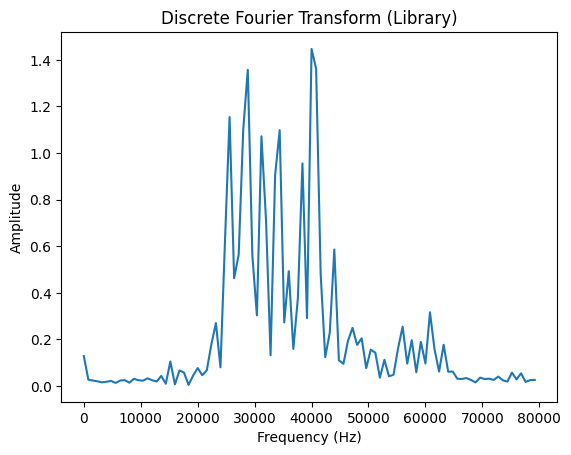

In [1302]:
# DISCRETE FOURIER ANALYSIS USING SCIPY LIBRARY
# ----------------------------------------------

# For measuring execution time. 
start = time.time()

# Number of samples in normalized_tone
yf = fft(testsample)
xf = fftfreq(N, 1 / sampling_frequency)[:(N // 2)]

end = time.time()
print("Using the scipy library, " + str(N) + " were analyzed in " + str(end - start) + " seconds.")

plt.plot(xf, 2 / N * np.abs(yf[0 : N//2]))        # Ignore this error 
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Discrete Fourier Transform (Library)")
plt.show()

## Sliding Fourier Transform for Edge Detection

In [1303]:
sampling_frequency                          # Sampling frequency of the hydrophone
N = 128                                     # The size of the shifting window in terms of the number of samples in the window 
startingIndex = 0000                        # This is the index of the first sample to be analyzed in the csv file data which is passed to the fourier analysis
endingIndex = 8000                          # This is the index of the last sample to be analyzed in the csv file data which is passed to the fourier analysis
sample                                      # The data that is to be input into the fourier analysis 

print("The sampling frequency is " + str(sampling_frequency))
print("The sample size is " + str(N))
print("The bucket size from the FFT is " + str(sampling_frequency / N))
print("The higheset frequency captured from the FFT is " + str(sampling_frequency / 2))

The sampling frequency is 160000
The sample size is 128
The bucket size from the FFT is 1250.0
The higheset frequency captured from the FFT is 80000.0


In [1304]:
chosenBucketSize = 1250
frequencyToWatch = 35000

sampleNumberArray = []
amplitudeArray = []

for i in range(startingIndex, (endingIndex - N + 1)):

    slidingTestSample = np.array(sample[i: i + N])

    yf = fft(slidingTestSample)
    xf = fftfreq(N, 1 / sampling_frequency)[:(N // 2)]

    frequencies = pd.DataFrame(xf, columns = ["Frequency"])
    amplitudes = pd.DataFrame((2 / N * np.abs(yf[0 : N//2])), columns = ["Amplitude"])

    values = pd.concat([frequencies, amplitudes], axis = 1)

    temp = chosenBucketSize / (sampling_frequency / N)
    index = 0
    newValues = pd.DataFrame(columns = ["Frequency", "Amplitude"])

    currentFrequency = 0
    currentAmplitude = 0

    for j in range(values.shape[0]):
        currentAmplitude = currentAmplitude + values["Amplitude"][j]

        if (index == 0):
            currentFrequency = values["Frequency"][j]
        
        index = index + 1

        if (index == temp):
            tempRowDictionary = {"Frequency": currentFrequency, "Amplitude": currentAmplitude}
            tempdf = pd.DataFrame([tempRowDictionary])
            newValues = pd.concat([newValues, tempdf], axis = 0, ignore_index = True)

            currentAmplitude = 0
            index = 0
    

    sampleNumberArray.append(i)
    amplitudeArray.append((newValues.loc[newValues['Frequency'] == frequencyToWatch]).iloc[0, 1])

for i in range(len(sampleNumberArray)):
    print(str(sampleNumberArray[i]) + "\t\t" + str(amplitudeArray[i]))

0		0.027687472547942696
1		0.03234437929268333
2		0.034643643622670535
3		0.042685132995756166
4		0.039964662740960576
5		0.04462391614500538
6		0.03664182594811042
7		0.031190545726355993
8		0.029196292626058086
9		0.029554364606674217
10		0.038381048355542124
11		0.03938384897883534
12		0.04506788461370648
13		0.03731211517386842
14		0.03553707091393248
15		0.029934398799631955
16		0.027056451605703052
17		0.03306101663844434
18		0.03397910664793658
19		0.04162670443772924
20		0.039280637568547105
21		0.03961824718410921
22		0.02947680199655999
23		0.02563939320515112
24		0.033397558634978626
25		0.03518577099298689
26		0.0418505943368988
27		0.03821823844987348
28		0.04336220644008154
29		0.035042854253533526
30		0.02768654371937721
31		0.0281914449218145
32		0.028928643991937654
33		0.03811181952410659
34		0.038899076819436766
35		0.04367031387945728
36		0.03565131535593568
37		0.032640831436365966
38		0.028971975760964774
39		0.02804031884172114
40		0.03485299907522681
41		0.03536

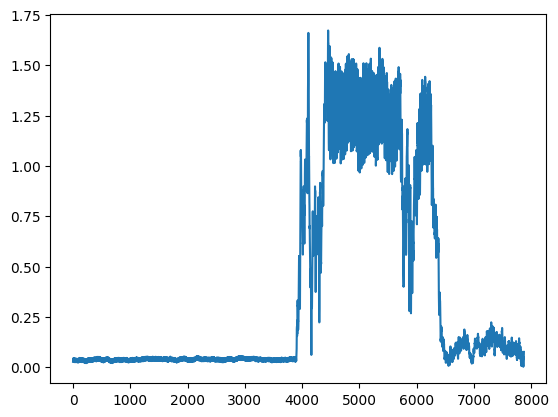

In [1305]:
plt.plot(sampleNumberArray, amplitudeArray)

Using the scipy library, 128 were analyzed in 0.0002460479736328125 seconds.


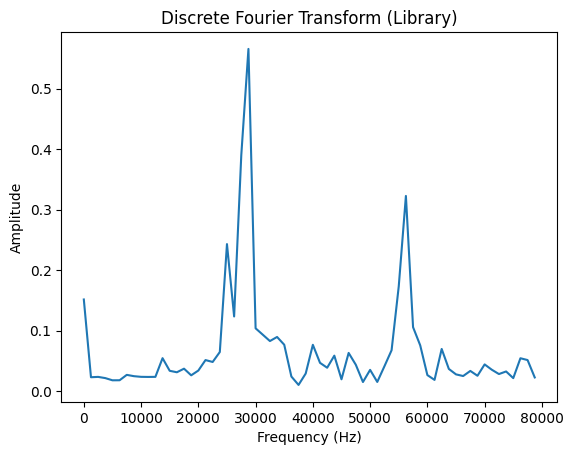

In [1306]:
# DISCRETE FOURIER ANALYSIS USING SCIPY LIBRARY
# ----------------------------------------------

# For measuring execution time. 
start = time.time()

# Number of samples in normalized_tone
yf = fft(slidingTestSample)
xf = fftfreq(N, 1 / sampling_frequency)[:(N // 2)]

end = time.time()
print("Using the scipy library, " + str(N) + " were analyzed in " + str(end - start) + " seconds.")

plt.plot(xf, 2 / N * np.abs(yf[0 : N//2]))        # Ignore this error 

plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Discrete Fourier Transform (Library)")
plt.show()

In [1307]:
pd.DataFrame(xf)
pd.DataFrame()

""
